#HW1 - Data Exploration and Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the dataset

In [2]:
dataset = pd.read_csv('virus_data.csv')

In [3]:
dataset.shape

(1250, 26)

In [4]:
def visualize_clf(clf, X, Y, title, 
                  xlabel, ylabel,
                  marker_size=50,
                  grid_length=300,
                  linewidths=None):
    import matplotlib.pyplot as plt
    import pandas as pd
    from matplotlib.colors import ListedColormap
    
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
        
    # For internal use here, make sure labels are 0 and 1
    Y = np.ravel(Y).astype(int)
    labels = set(Y)
    assert len(labels) == 2, "Can only visualize two unique labels"

    if labels == set([-1,1]):
      Y = (Y + 1) // 2
      labels = set(Y)
    
    assert labels == set([0,1]), "Could not handle given labels"

    plt.figure(figsize=(8, 8))

    # Parameters
    n_classes = 2
    markers = ["D", "o"]
    palette = sns.color_palette("hls", 2)
    custom_cmap = ListedColormap(palette.as_hex())

    x_delta = np.abs(X[:, 0].max() - X[:, 0].min()) * 0.1
    y_delta = np.abs(X[:, 1].max() - X[:, 1].min()) * 0.1
    x_min, x_max = X[:, 0].min() - x_delta, X[:, 0].max() + x_delta
    y_min, y_max = X[:, 1].min() - y_delta, X[:, 1].max() + y_delta
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_length),
                         np.linspace(y_min, y_max, grid_length))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cs = plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.35)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.75)

    # Plot the training points
    for i, color, marker in zip(labels, palette, markers):
        idx = np.where(Y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=color,
                    marker=marker,
                    edgecolor='white', s=marker_size,
                    linewidths=linewidths)

    plt.title(title, fontsize=20)
    plt.axis("tight")
    plt.show()

In [5]:
def plot3d(df, colX, colY, colZ, title, hue=None, s=1):
  %matplotlib inline

  fig = plt.figure(figsize=(20, 4))
  axes = [fig.add_subplot(1, 4, 1, projection='3d'),
          fig.add_subplot(1, 4, 2, projection='3d'),
          fig.add_subplot(1, 4, 3, projection='3d'),
          fig.add_subplot(1, 4, 4, projection='3d')]

  palette = sns.color_palette("hls", 2)

  for i,ax in enumerate(axes):
    if hue is None:
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=s)
    else:
      idx = df[hue] == True
      df1 = df[idx]
      df2 = df[~idx]

      ax.scatter3D(df1[colX], df1[colY], df1[colZ], color=palette[0], s=s)
      ax.scatter3D(df2[colX], df2[colY], df2[colZ], color=palette[1], s=s)

    if i == 3 or i == 1:
      ax.set_xlabel(colX, labelpad=20)
      ax.set_ylabel(colY, labelpad=20)
    else:
      ax.xaxis.set_ticklabels([])
      ax.yaxis.set_ticklabels([])

    ax.view_init(elev=5., azim=45*i+15)

  axes[1].set_zlabel("\n" + colZ, labelpad=1)

  plt.suptitle(title)
  plt.subplots_adjust(wspace=0.1, top=0.99)
  plt.show()

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


def prepare_data(training_data, new_data):

  # Copy the data
  train_df = training_data.copy()
  new_df = new_data.copy()

  # Add the SpecialProperty column & drop blood_type
  group_True = ['O+', 'B+']
  train_df['SpecialProperty'] = np.where(train_df['blood_type'].isin(group_True), 1, -1)
  new_df['SpecialProperty'] = np.where(new_df['blood_type'].isin(group_True), 1, -1)
  train_df = train_df.drop('blood_type', axis=1)
  new_df = new_df.drop('blood_type', axis=1)

  # Split the symptoms variable into columns
  train_df_new_cols = train_df['symptoms'].str.get_dummies(';')
  train_df_new_cols[train_df_new_cols == 0] = -1

  new_df_new_cols = new_df['symptoms'].str.get_dummies(';')
  new_df_new_cols[new_df_new_cols == 0] = -1

  train_df = pd.concat([train_df, train_df_new_cols], axis=1)
  new_df = pd.concat([new_df, new_df_new_cols], axis=1)

  train_df = train_df.drop('symptoms', axis=1)
  new_df = new_df.drop('symptoms', axis=1)

  # Split the gender column into "Male" and "Female"
  train_df['Female'] = np.where(train_df['sex'] == 'F', 1, -1)
  train_df['Male'] = np.where(train_df['sex'] == 'M', 1, -1)
  train_df = train_df.drop('sex', axis=1)

  new_df['Female'] = np.where(new_df['sex'] == 'F', 1, -1)
  new_df['Male'] = np.where(new_df['sex'] == 'M', 1, -1)
  new_df = new_df.drop('sex', axis=1)

  # Split location column into location_x and location_y
  train_df['location_x'] = [float(location.split("'")[1]) for location in train_df['current_location']]
  train_df['location_y'] = [float(location.split("'")[3]) for location in train_df['current_location']]
  train_df = train_df.drop('current_location', axis=1)

  new_df['location_x'] = [float(location.split("'")[1]) for location in new_df['current_location']]
  new_df['location_y'] = [float(location.split("'")[3]) for location in new_df['current_location']]
  new_df = new_df.drop('current_location', axis=1)

  train_df = train_df.drop('pcr_date', axis=1)
  train_df = train_df.drop('patient_id', axis=1)
  new_df = new_df.drop('pcr_date', axis=1)
  new_df = new_df.drop('patient_id', axis=1)


  # Columns designated for minmax scaling
  cols_for_minmax = ['PCR_01','PCR_02','PCR_03','PCR_06','cough','fever',
                    'shortness_of_breath','smell_loss','sore_throat','Female','Male', 'SpecialProperty']
  # Columns designated for standrad scaling
  cols_for_standard = ['age','weight','num_of_siblings','happiness_score','household_income',
                   'conversations_per_day','sugar_levels','sport_activity','location_x',
                   'location_y','PCR_04','PCR_05','PCR_07','PCR_08','PCR_09','PCR_10']

  # minmax scale all the minmax columns (in both training & test data, fit only training)
  scaler = MinMaxScaler(feature_range=(-1,1))
  scaler.fit(train_df[cols_for_minmax])
  new_df[cols_for_minmax] = scaler.transform(new_df[cols_for_minmax])

  # Standard scale all the standard columns
  scaler = StandardScaler()
  scaler.fit(train_df[cols_for_standard])
  new_df[cols_for_standard] = scaler.transform(new_df[cols_for_standard])

  return new_df

In [7]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(dataset, test_size=0.2, train_size=0.8, random_state=25)

# Prepare training set according to itself
train_df_preprocessed = prepare_data(data_train, data_train)

# Prepare test set according to the raw training set
test_df_preprocessed = prepare_data(data_train, data_test)

# Export the training DataFrame to a CSV file
train_df_preprocessed.to_csv('training_preprocessed.csv', index=False)

# Export the test DataFrame to a CSV file
test_df_preprocessed.to_csv('test_preprocessesd.csv', index=False)

Part 1: Basic model selection with k-Nearest Neighbors

Q1: Training a 1-NN model

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


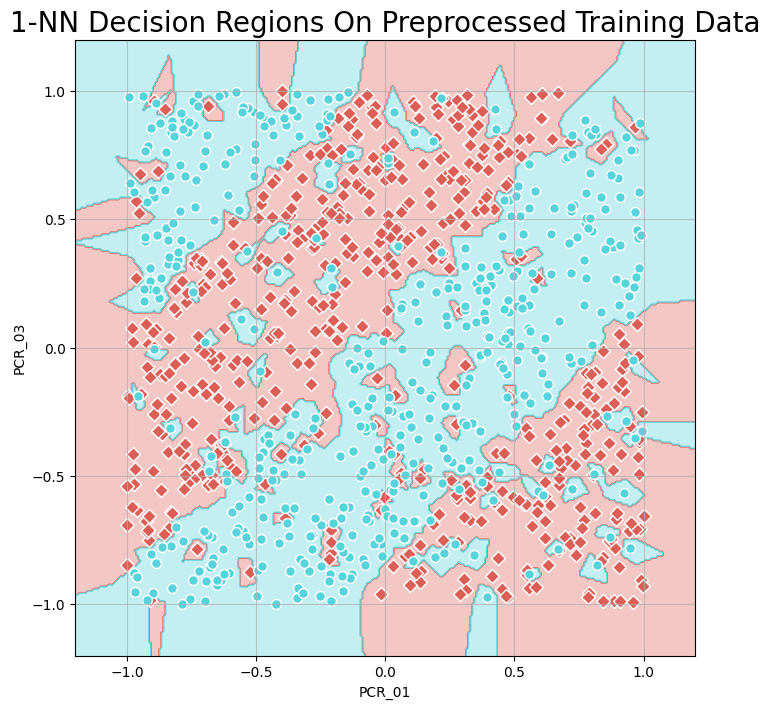

In [8]:
from sklearn.neighbors import KNeighborsClassifier

temp_df = train_df_preprocessed[['PCR_01', 'PCR_03']]

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(temp_df, train_df_preprocessed['spread'])
visualize_clf(knn, temp_df, train_df_preprocessed['spread'], "1-NN Decision Regions On Preprocessed Training Data",
               "PCR_01", "PCR_03")

Q2: Cross Validation

Best k value:  13
Its mean validation score:  0.8560000000000001
Its mean training score:  0.8641428571428571


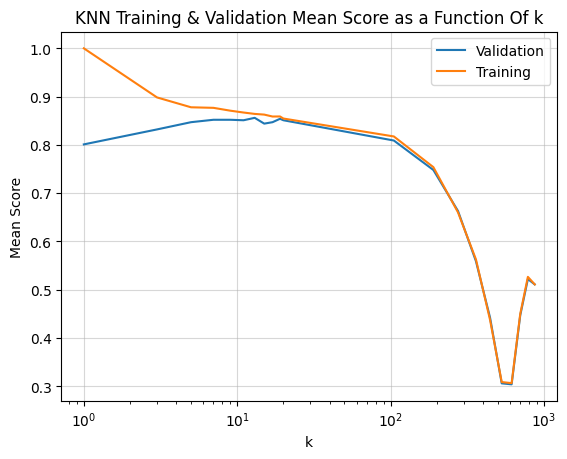

In [9]:
from sklearn.model_selection import cross_validate

# Save statistics in lists
validation_scores = []
training_scores = []
k_values = list(range(1, 20, 2)) + list(range(20, 871, 85))

# Iterate over different values of k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_results = cross_validate(knn, temp_df, train_df_preprocessed['spread'], cv=8, return_train_score=True)

    # Save mean scores
    validation_scores.append(cv_results['test_score'].mean())
    training_scores.append(cv_results['train_score'].mean())

# Plot the results
plt.semilogx(k_values, validation_scores, k_values, training_scores)
plt.xlabel('k')
plt.ylabel('Mean Score')
plt.title('KNN Training & Validation Mean Score as a Function Of k')
plt.legend(['Validation', 'Training'])
plt.grid(alpha=0.5)

print("Best k value: ", k_values[np.argmax(validation_scores)])
print("Its mean validation score: ", validation_scores[np.argmax(validation_scores)])
print("Its mean training score: ", training_scores[np.argmax(validation_scores)])

Q3: Training a K-NN With Optimal K Value

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


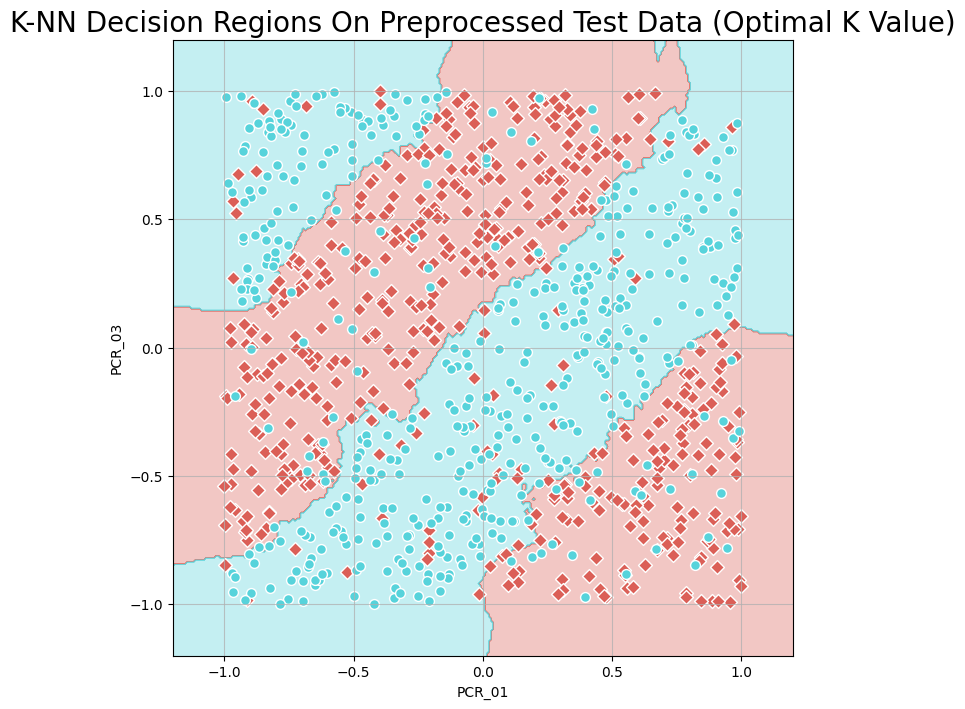

The test accuracy for the bets k value is: 0.868


In [10]:
# Create a KNN classifier with the best k value
knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(temp_df, train_df_preprocessed['spread'])

# Visualize the decision regions
visualize_clf(knn, temp_df, train_df_preprocessed['spread'], "K-NN Decision Regions On Preprocessed Test Data (Optimal K Value)",
               "PCR_01", "PCR_03")

print("The test accuracy for the bets k value is:", knn.score(test_df_preprocessed[['PCR_01', 'PCR_03']], test_df_preprocessed['spread']))

Part 3: Decision Trees 

Q5: Training A Decision Tree With Max Depth Of 3

Training accuracy is:  0.713


[Text(0.5, 0.875, 'PCR_02 <= -0.43\nentropy = 0.999\nsamples = 1000\nvalue = [481, 519]\nclass = High'),
 Text(0.25, 0.625, 'SpecialProperty <= 0.0\nentropy = 0.894\nsamples = 209\nvalue = [65, 144]\nclass = High'),
 Text(0.125, 0.375, 'PCR_06 <= 0.025\nentropy = 0.999\nsamples = 103\nvalue = [53, 50]\nclass = Low'),
 Text(0.0625, 0.125, 'entropy = 0.619\nsamples = 52\nvalue = [44, 8]\nclass = Low'),
 Text(0.1875, 0.125, 'entropy = 0.672\nsamples = 51\nvalue = [9, 42]\nclass = High'),
 Text(0.375, 0.375, 'PCR_04 <= 0.491\nentropy = 0.51\nsamples = 106\nvalue = [12, 94]\nclass = High'),
 Text(0.3125, 0.125, 'entropy = 0.605\nsamples = 81\nvalue = [12, 69]\nclass = High'),
 Text(0.4375, 0.125, 'entropy = 0.0\nsamples = 25\nvalue = [0, 25]\nclass = High'),
 Text(0.75, 0.625, 'PCR_02 <= 0.535\nentropy = 0.998\nsamples = 791\nvalue = [416.0, 375.0]\nclass = Low'),
 Text(0.625, 0.375, 'PCR_06 <= -0.54\nentropy = 0.969\nsamples = 580\nvalue = [350, 230]\nclass = Low'),
 Text(0.5625, 0.125, 'e

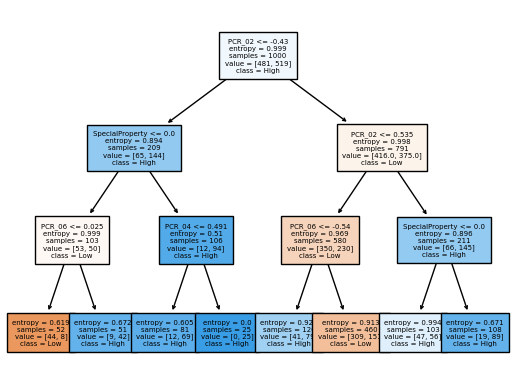

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# Create a decision tree classifier
id3_dt = DecisionTreeClassifier(random_state=25, max_depth=3, criterion='entropy')

temp_df = train_df_preprocessed.drop('risk', axis=1)
temp_df = temp_df.drop('spread', axis=1)

# Fit the classifier to the training data
id3_dt.fit(temp_df, train_df_preprocessed['risk'])

print("Training accuracy is: ", id3_dt.score(temp_df, train_df_preprocessed['risk']))

# Visualize the decision tree
plot_tree(id3_dt, feature_names=temp_df.columns, class_names=['Low', 'High'], filled=True, fontsize=5)

Q6: Hyperparameter Tuning In ID3

{'max_depth': 8, 'min_samples_leaf': 13}
Validation accuracy is:  0.7639999999999999


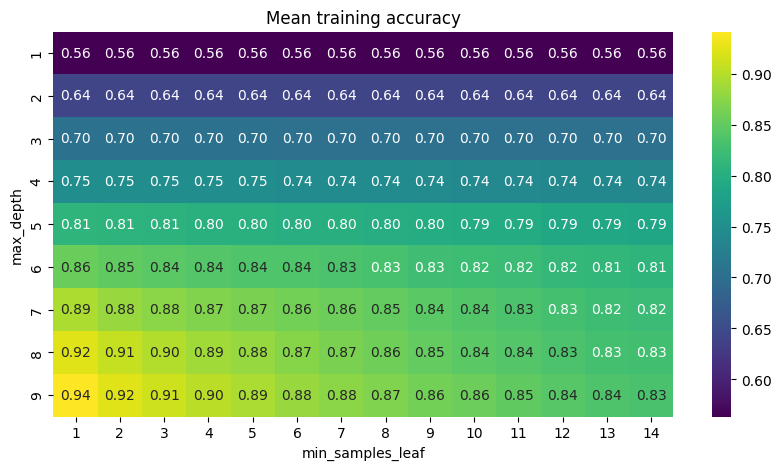

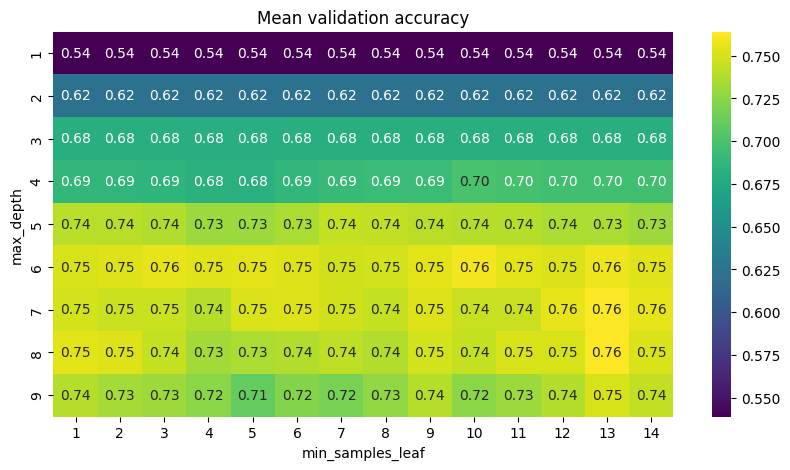

In [12]:
from sklearn.model_selection import GridSearchCV

# Set parameters for grid search
parameters = {'max_depth': list(range(1, 10)), 'min_samples_leaf': list(range(1, 15))}

# Create a decision tree classifier and perform grid search
dt_id3 = DecisionTreeClassifier(criterion='entropy', random_state=25)
cv_results = GridSearchCV(dt_id3, parameters, cv=5, return_train_score=True)
cv_results.fit(train_df_preprocessed.drop(['risk', 'spread'], axis=1), train_df_preprocessed['risk'])

print(cv_results.best_params_)
print("Validation accuracy is: ", cv_results.best_score_)

# Extract results 
results = pd.DataFrame(cv_results.cv_results_)

# Visualize the decision tree
train_scores = results.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_train_score')
test_scores = results.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_test_score')

# Plot mean training & validation scores
plt.figure(figsize=(10, 5))
sns.heatmap(train_scores, annot=True, cmap='viridis', fmt=".2f")
plt.xlabel('min_samples_leaf')
plt.ylabel('max_depth')
plt.title('Mean training accuracy')
plt.show()

plt.figure(figsize=(10, 5))
sns.heatmap(test_scores, annot=True, cmap='viridis', fmt=".2f")
plt.xlabel('min_samples_leaf')
plt.ylabel('max_depth')
plt.title('Mean validation accuracy')
plt.show()

Q8: Training a decision tree with optimal hyperparameters

In [13]:
# Create a decision tree with optimal depth and min_samples_leaf
dt_id3 = DecisionTreeClassifier(criterion='entropy', random_state=25, max_depth=8, min_samples_leaf=13)
dt_id3.fit(train_df_preprocessed.drop(['risk', 'spread'], axis=1), train_df_preprocessed['risk'])

acc = dt_id3.score(test_df_preprocessed.drop(['risk', 'spread'], axis=1), test_df_preprocessed['risk'])
print("Test accuracy for best hyperparameters: ", acc)

Test accuracy for best hyperparameters:  0.732


Part 3 SVM with a polynomial kernel

In [14]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

class SoftSVM(BaseEstimator, ClassifierMixin):
    """
    Custom C-Support Vector Classification.
    """
    def __init__(self, C: float, lr: float = 1e-5, batch_size = 32):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param C: inverse strength of regularization. Must be strictly positive.
        :param lr: the SGD learning rate (step size)
        """
        self.C = C
        self.lr = lr
        self.batch_size = batch_size
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.random.randn(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, C: float, X, y):
        """
        Compute the SVM objective loss.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the Soft SVM objective loss (float scalar)
        """
        margins = (X.dot(w) + b)
        hinge_inputs = np.multiply(margins, y)

        norm = np.linalg.norm(w)
        loss = C * np.sum(np.maximum(0, 1 - hinge_inputs)) + norm ** 2
        return loss

    @staticmethod
    def subgradient(w, b: float, C: float, X, y):
        """
        Compute the (analytical) SVM objective sub-gradient.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        # TODO: calculate the analytical sub-gradient of soft-SVM w.r.t w and b
        margins = (X.dot(w) + b)
        hinge_inputs = np.multiply(margins, y)
        f_vector = np.where(hinge_inputs < 1, -1, 0)
        y = np.array(y)
        inter = y[:, np.newaxis] * X
        g_w = C * np.sum(inter * f_vector[:, np.newaxis], axis=0) + 2 * w
        g_b = C * np.sum(y * f_vector)

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 2000, keep_losses: bool = True):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets (+1 and -1); array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses:
        :return: the training losses and accuracies during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        losses = []
        accuracies = []

        if keep_losses:
            losses.append(self.loss(self.w, self.b, self.C, X, y))
            accuracies.append(self.score(X, y))

        permutation = np.random.permutation(len(y))
        X = X[permutation, :]
        y = y[permutation]
        
        # Iterate over batches
        for iter in range(0, max_iter):
            start_idx = (iter * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx:end_idx, :]
            batch_y = y[start_idx:end_idx]

            # TODO: Compute the (sub)gradient of the current *batch*
            g_w, g_b = self.subgradient(self.w, self.b, self.C, batch_X, batch_y)

            # Perform a (sub)gradient step
            # TODO: update the learned parameters correctly
            self.w = self.w - self.lr * g_w
            self.b = self.b - self.lr * g_b

            if keep_losses:
                losses.append(self.loss(self.w, self.b, self.C, X, y))
                accuracies.append(self.score(X, y))

        return losses, accuracies

    def fit(self, X, y, max_iter: int = 2000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets (+1 and -1); array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Perform classification on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted class labels for samples in X; array of shape (n_samples,)
                 NOTE: the labels must be either +1 or -1
        """
        # TODO: compute the predicted labels (+1 or -1)
        vec = X.dot(self.w) + self.b
        y_pred = np.where(vec > 0, 1, -1)
        return y_pred


In [15]:
def numerical_subgradient(w, b, C, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = SoftSVM.loss(w_, b, C, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = SoftSVM.loss(w_, b, C, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (SoftSVM.loss(w_, b + delta, C, X, y) - orig_objective) / delta
    return g_w, g_b



def compare_gradients(X, y, deltas, C=1, REPEATS=100, figsize=(10, 6)):
    residual_means = []

    for delta in deltas:
        residuals = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            
            numeric_grad = numerical_subgradient(w, b, C, X, y, delta=delta)[0]
            analytic_grad = SoftSVM.subgradient(w, b, C, X, y)[0]
            residual = np.linalg.norm(numeric_grad - analytic_grad)
            residuals.append(residual)

        residual_means.append(np.mean(residuals))

    plt.figure(figsize=figsize)
    plt.title('Residuals of analytical and numerical gradients', fontsize=22)
    plt.plot(deltas, residual_means, linewidth=3)      
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$\delta$', fontsize=18)
    plt.ylabel(r'$\left\Vert \nabla_{w}p_{C}\left(w,b\right) - u_{\delta} \left(w,b\right)\right\Vert$', fontsize=18)

    plt.grid(alpha=0.5)
    plt.show()


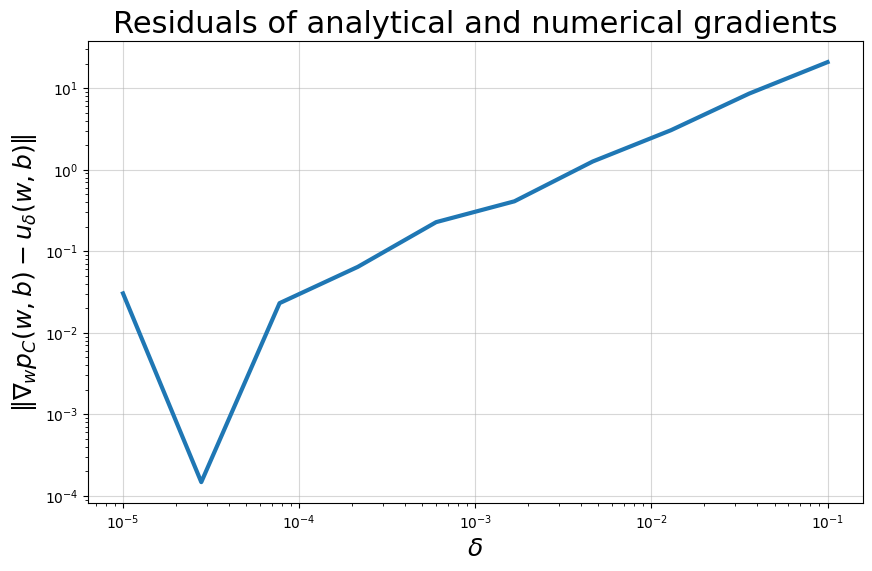

In [16]:
compare_gradients(temp_df, train_df_preprocessed['spread'], deltas=np.logspace(-5, -1, 10))

Learning rate is:  1e-09 



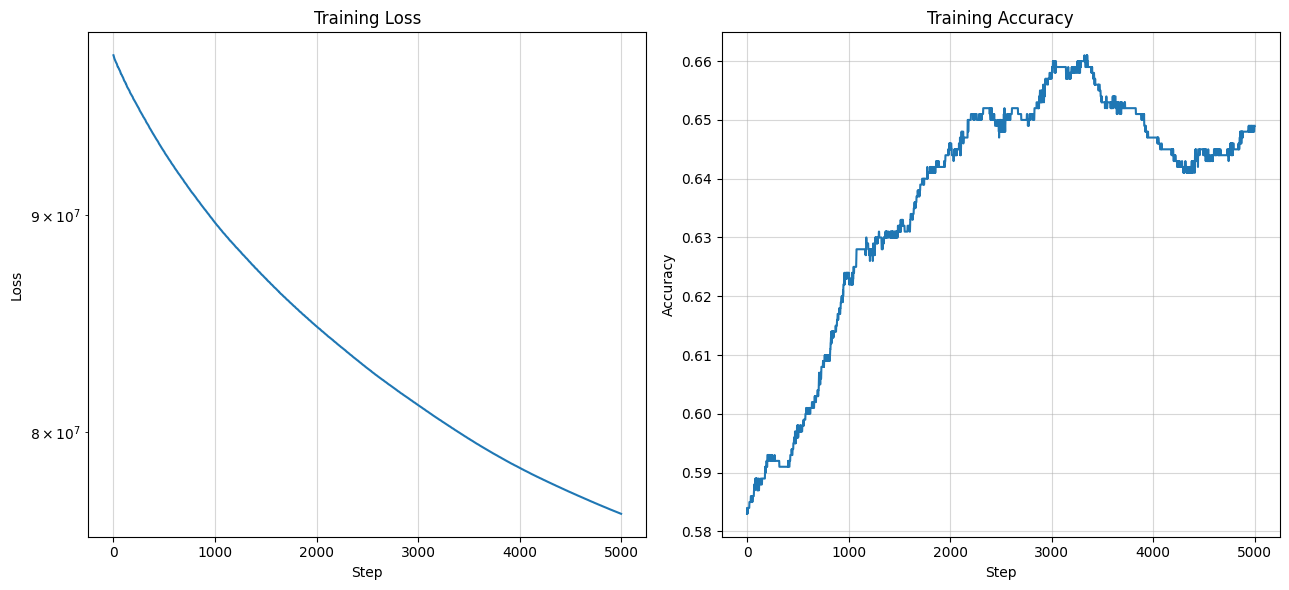

Learning rate is:  1e-08 



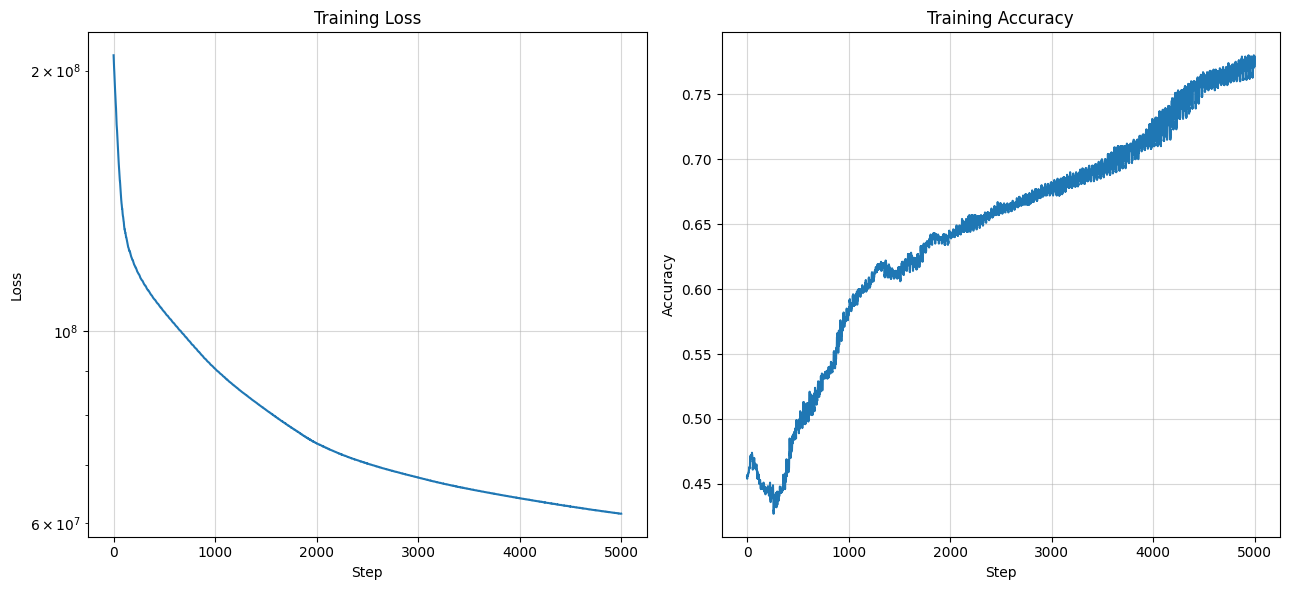

Learning rate is:  1e-07 



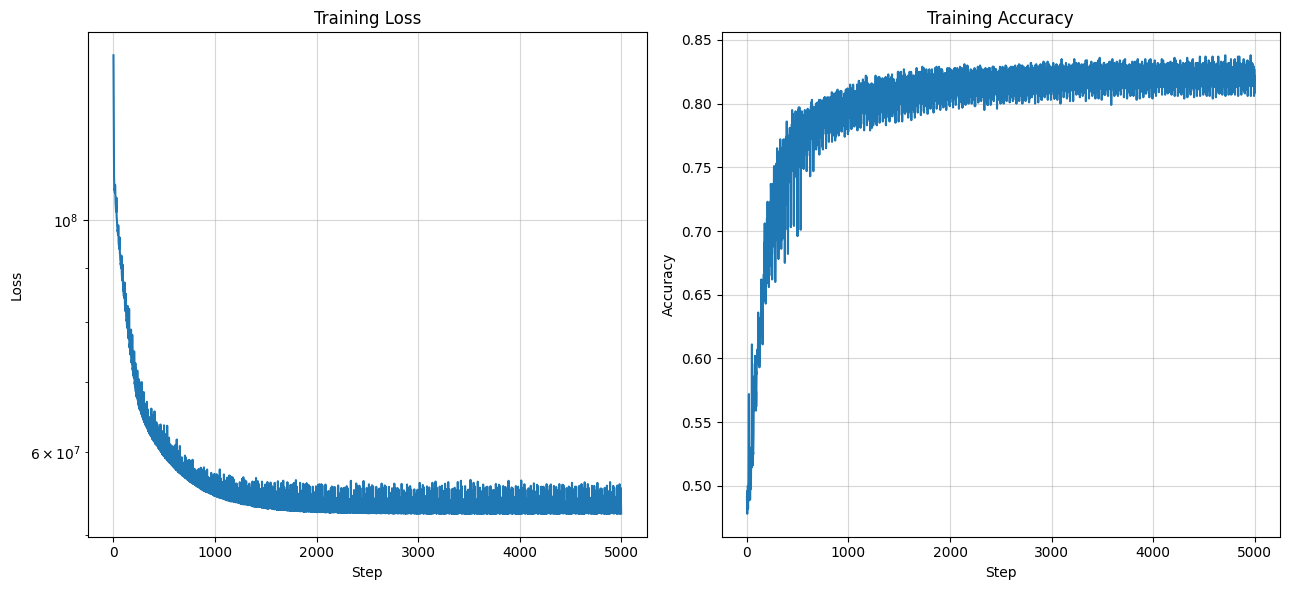

Learning rate is:  1e-06 



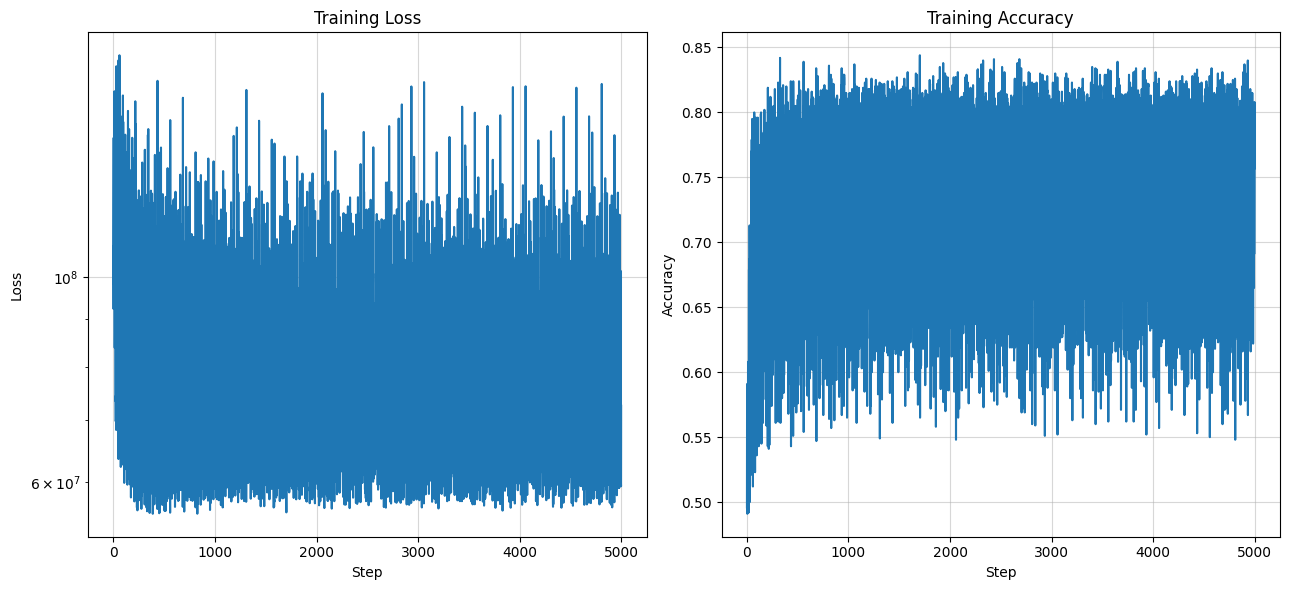

Learning rate is:  1e-05 



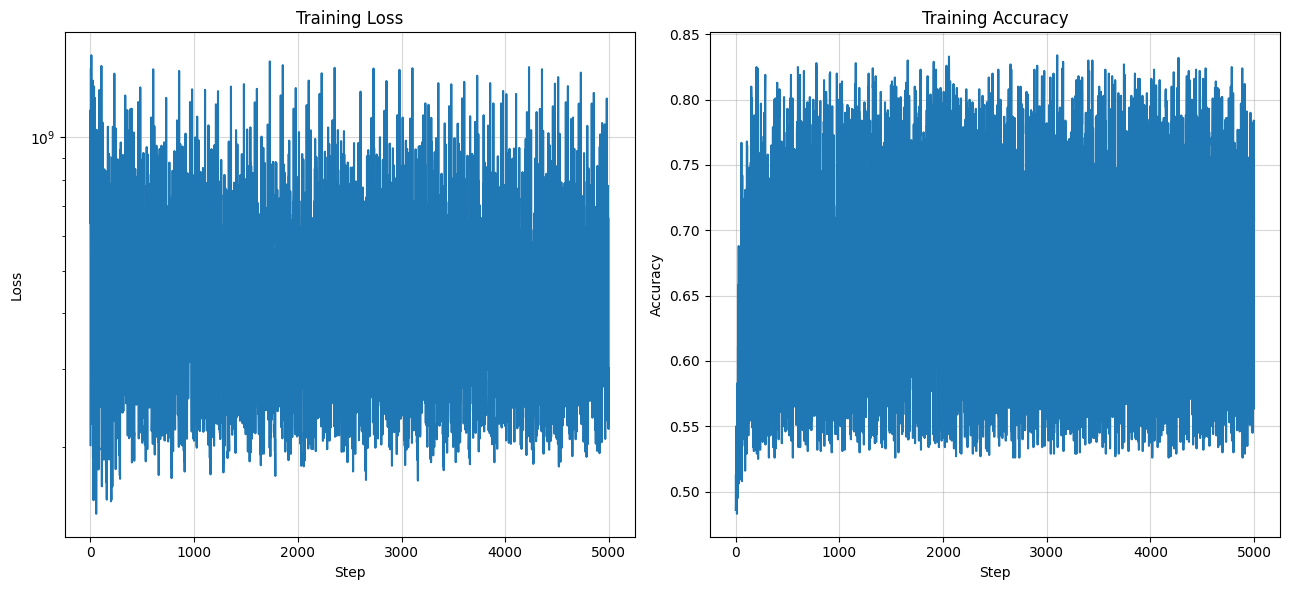

In [17]:
from sklearn.preprocessing import PolynomialFeatures

for lr in np.logspace(-9,-5,5):
    print("Learning rate is: ", lr, "\n")
    C=1e5
    clf = SoftSVM(C=C, lr=lr)
    Xtrain = temp_df[['PCR_01', 'PCR_03']]
    ytrain = train_df_preprocessed['spread']
    Xtrain_poly = PolynomialFeatures(degree=3).fit_transform(Xtrain)
    Xtrain_poly = MinMaxScaler(feature_range=(-1,1)).fit_transform(Xtrain_poly)
    losses, accuracies = clf.fit_with_logs(Xtrain_poly, np.array(ytrain), max_iter=5000)
    plt.figure(figsize=(13, 6))
    plt.subplot(121), plt.grid(alpha=0.5), plt.title ("Training Loss")
    plt.semilogy(losses), plt.xlabel("Step"), plt.ylabel("Loss")
    plt.subplot(122), plt.grid(alpha=0.5), plt.title ("Training Accuracy")
    plt.plot(accuracies), plt.xlabel("Step"), plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.show()


Q12: Training A SoftSVm

Training accuracy is:  0.817
Test accuracy is:  0.812


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


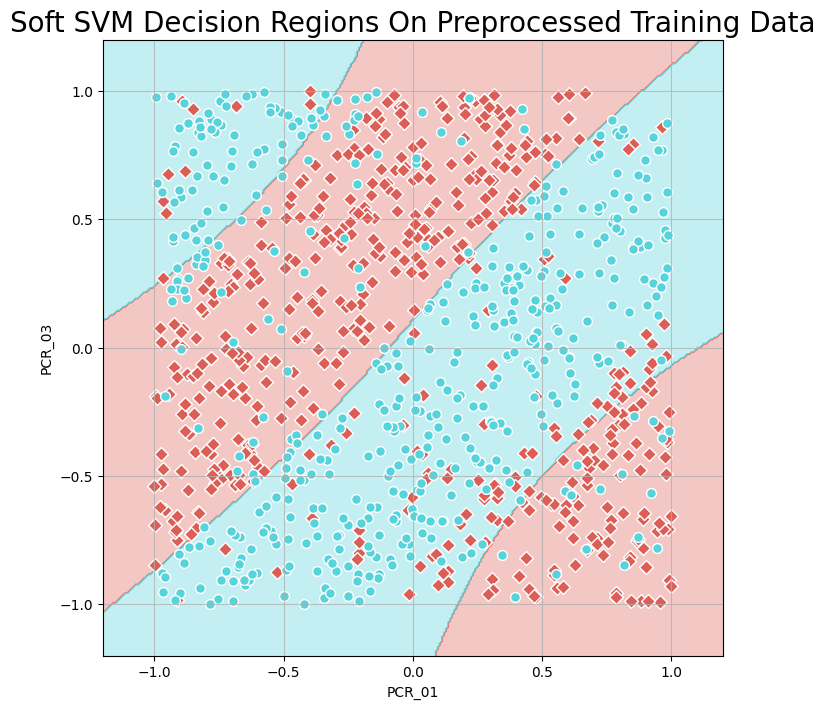

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

svm_clf = Pipeline([('feature_mapping', PolynomialFeatures(degree=3)),
('scaler', MinMaxScaler()),
('SVM', SoftSVM(C=1e5, lr=1e-7))])
svm_clf.fit(temp_df[['PCR_01', 'PCR_03']], np.array(train_df_preprocessed['spread']), SVM__max_iter=5000)
print("Training accuracy is: ", svm_clf.score(train_df_preprocessed[['PCR_01', 'PCR_03']], train_df_preprocessed['spread']))
print("Test accuracy is: ", svm_clf.score(test_df_preprocessed[['PCR_01', 'PCR_03']], test_df_preprocessed['spread']))

# Plot the decision regions
visualize_clf(svm_clf, temp_df[['PCR_01', 'PCR_03']], train_df_preprocessed['spread'], "Soft SVM Decision Regions On Preprocessed Training Data",
               "PCR_01", "PCR_03")

Part 5: Custom Feature Mapping

Q16

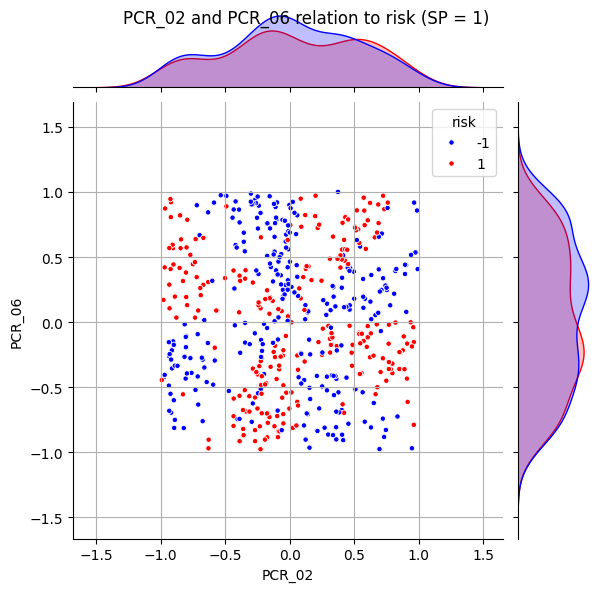

In [19]:
# Filter train data according to the special property and select features PCR_02 and PCR_06 along with the risk label
temp_data_train = train_df_preprocessed[train_df_preprocessed['SpecialProperty'] == -1]
temp_data_train = temp_data_train[['PCR_02', 'PCR_06', 'risk']]
# Filter test data according to the special property and select features PCR_02 and PCR_06 along with the risk label
temp_data_test = test_df_preprocessed[test_df_preprocessed['SpecialProperty'] == -1]
temp_data_test = temp_data_test[['PCR_02', 'PCR_06', 'risk']]

# Define a custom color palette
custom_palette = ['blue', 'red']
goinplot = sns.jointplot(data=temp_data_train, x='PCR_02', y='PCR_06', hue='risk', palette=custom_palette, marker='.', s=60)
goinplot.ax_joint.grid(True)
goinplot.set_axis_labels(xlabel="PCR_02", ylabel="PCR_06")
goinplot.ax_joint.legend(title='risk')
goinplot.figure.suptitle("PCR_02 and PCR_06 relation to risk (SP = 1)")
plt.show()

Q17

In [20]:
# Calculate the angle between PCR_02 and PCR_06 the angle from one of the axes
train_angles = np.arctan2(temp_data_train['PCR_06'], temp_data_train['PCR_02'])
test_angles = np.arctan2(temp_data_test['PCR_06'], temp_data_test['PCR_02'])
# Store the angles in a new column 
temp_data_train['angle'] = train_angles
temp_data_test['angle'] = test_angles

Q17

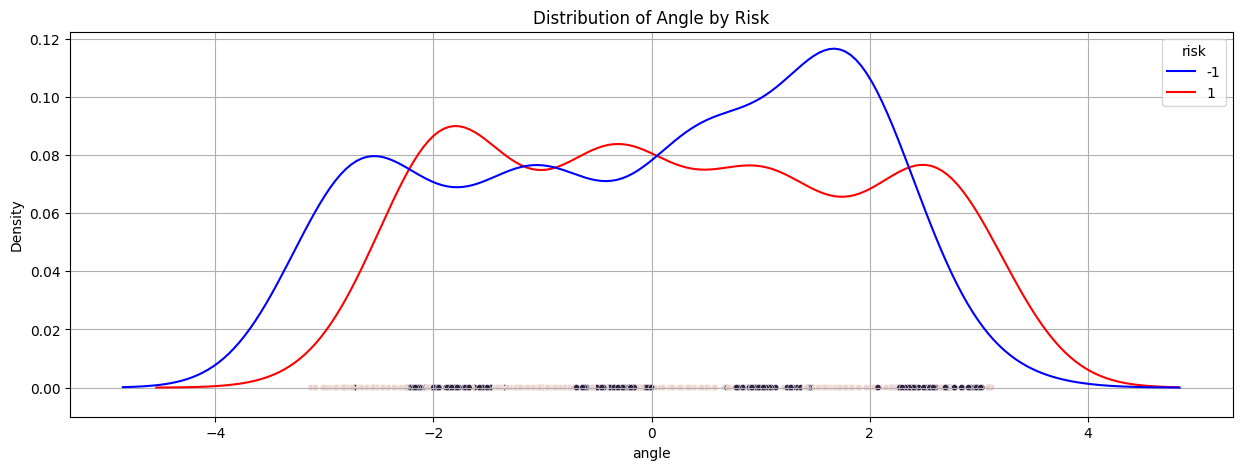

In [21]:
# visualizes the distribution of the new mapped feature
plt.figure(figsize=(15, 5))
sns.scatterplot(data=temp_data_train, x='angle', y=[0]*temp_data_train.shape[0], hue='risk', s=20)
sns.kdeplot(data= temp_data_train, x='angle', hue='risk', palette=custom_palette, common_norm=True, fill=False)
plt.ylim(bottom=-1e-2)
plt.title('Distribution of Angle by Risk')
plt.grid(True)

Q18

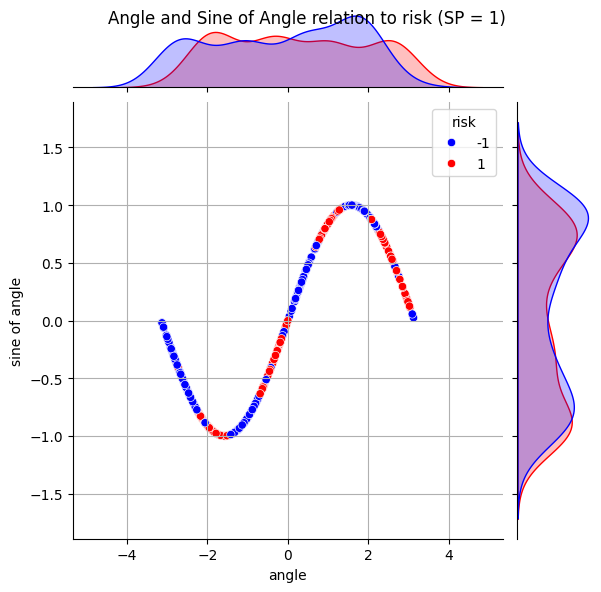

In [22]:
beta=1
temp_data_train['sin_angle'] = np.sin(beta*temp_data_train['angle'])
temp_data_test['sin_angle'] = np.sin(beta*temp_data_test['angle'])

# visualizes the distribution of the new mapped feature
jointplot = sns.jointplot(data=temp_data_train, x="angle", y="sin_angle", palette=custom_palette, hue="risk")
jointplot.ax_joint.grid(True)
jointplot.figure.suptitle("Angle and Sine of Angle relation to risk (SP = 1)")
jointplot.set_axis_labels(xlabel="angle", ylabel="sine of angle")
jointplot.ax_joint.legend(title='risk')
plt.show()

Q19

Best beta: 4.17
Train Accuracy: 0.8711538461538462
Test Accuracy: 0.8636363636363636


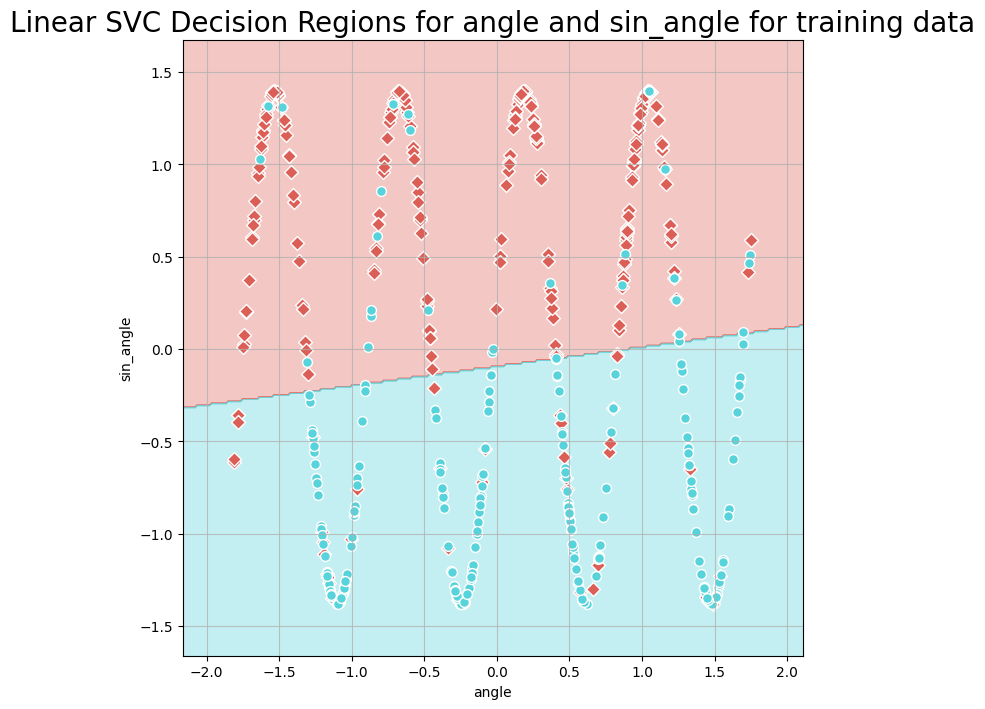

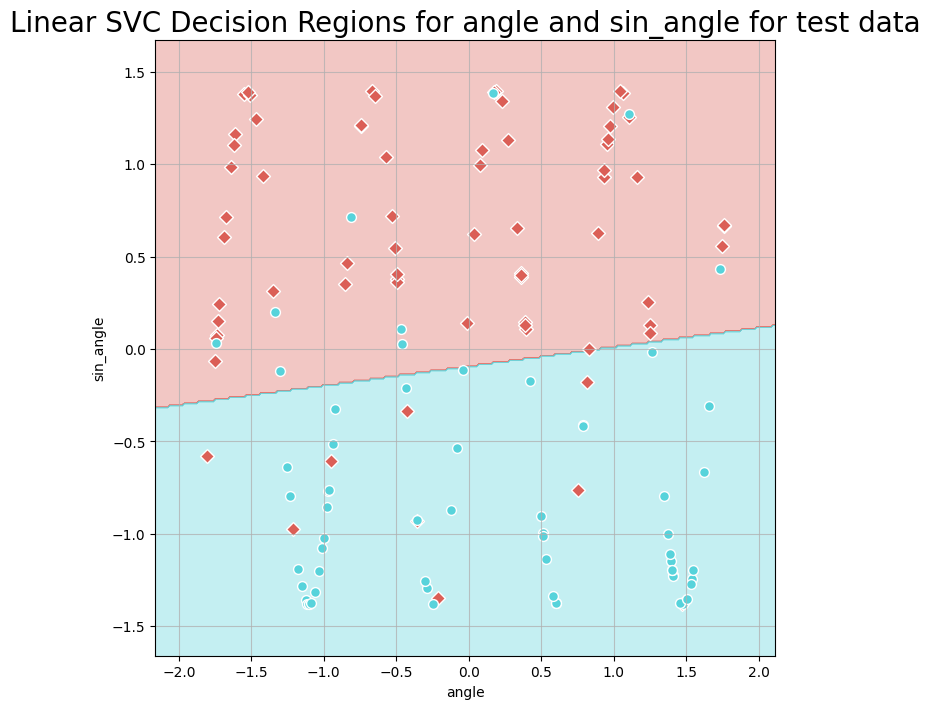

In [47]:
from sklearn.svm import LinearSVC
best_beta = None
best_train_acc = 0

for beta in np.arange(3.5, 4.5, 0.01):
    temp_data_train['sin_angle'] = np.sin(beta * temp_data_train['angle'])
    scaler = StandardScaler()
    X_train = scaler.fit_transform(temp_data_train[['angle', 'sin_angle']])
    model = LinearSVC(dual='auto')
    model.fit(X_train, temp_data_train['risk'])
    temp_data_train['sin_angle'] = np.sin(beta * temp_data_train['angle'])
    X_test = scaler.transform(temp_data_train[['angle', 'sin_angle']])
    train_acc = model.score(X_test, temp_data_train['risk'])
    
    if train_acc > best_train_acc:
        best_train_acc = train_acc
        best_beta = beta

print("Best beta:", best_beta)

temp_data_train['sin_angle'] = np.sin(best_beta*temp_data_train['angle'])
# Normalize the mapped features
scaler = StandardScaler()
X_train = scaler.fit_transform(temp_data_train[['angle', 'sin_angle']])

# Train LinearSVC model on the updated mapping
model = LinearSVC(dual='auto')
model.fit(X_train, temp_data_train['risk'])

# Calculate training accuracy
train_acc = model.score(X_train, temp_data_train['risk'])

# Apply the same mapping and normalization to the test data
temp_data_test['sin_angle'] = np.sin(best_beta * temp_data_test['angle'])
X_test = scaler.transform(temp_data_test[['angle', 'sin_angle']])

# Calculate test accuracy
test_acc = model.score(X_test, temp_data_test['risk'])

print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

# Plot the decision regions for train data
visualize_clf(clf=model, X=X_train, Y=temp_data_train['risk'],
               title='Linear SVC Decision Regions for angle and sin_angle for training data',
              xlabel='angle', ylabel='sin_angle')

# Plot the decision regions for test data
visualize_clf(clf=model, X=X_test, Y=temp_data_test['risk'],
               title='Linear SVC Decision Regions for angle and sin_angle for test data',
              xlabel='angle', ylabel='sin_angle')

